# Challenge Caja los Andes: Para puesto de Data Scientist

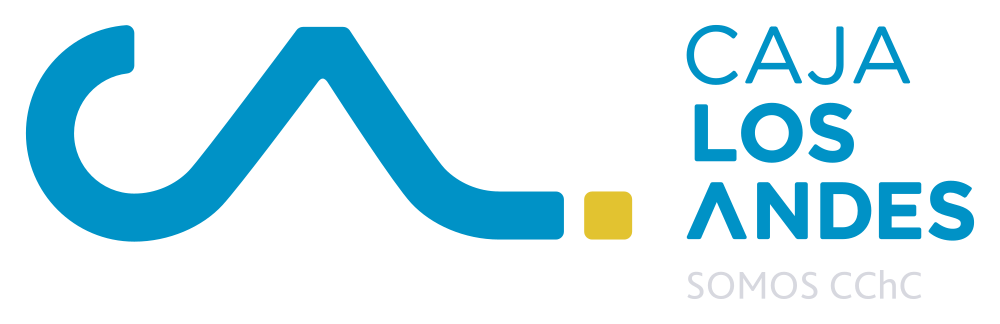

In [165]:
from IPython.display import SVG, display
def show_svg():
    display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/3/34/Logotipo_Caja_Los_Andes.svg'))
show_svg()

## a 

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statistics import mean
from matplotlib import pyplot
import matplotlib.patches as mpatches
import time
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline


colors = ["#0101DF", "#DF0101"]

df = pd.read_csv("../data/raw/dataset_Caso_1.csv")
df.info(verbose= "True")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   x3      2000 non-null   object 
 3   x4      2000 non-null   object 
 4   x5      2000 non-null   int64  
 5   x6      2000 non-null   int64  
 6   x7      2000 non-null   int64  
 7   x8      2000 non-null   float64
 8   target  2000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 140.8+ KB


In [5]:
df.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,SAT,MZBER,0,0,6,-6.5,0
1,50.1341,-326.0000,SAT,MZBER,0,0,6,-4.5,0
2,124.3276,-275.1935,LCV,MZBER,0,0,3,-2.5,0
3,50.1341,-326.0000,SAT,MZBER,0,0,3,-4.5,0
4,85.3905,-298.8632,XJB,MZBER,0,0,5,-4.5,0


In [8]:
df.describe()

,x1,x2,x5,x6,x7,x8,target
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,101.074885,-298.282145,0.01250,0.027000,3.440500,-5.343500,0.011000
std,22.670474,16.596490,0.11113,0.162124,0.972591,1.570108,0.104329
min,50.134100,-326.000000,0.00000,0.000000,3.000000,-7.500000,0.000000
25%,89.501675,-308.930400,0.00000,0.000000,3.000000,-6.500000,0.000000
50%,105.236100,-297.825600,0.00000,0.000000,3.000000,-5.500000,0.000000
75%,116.023175,-288.169025,0.00000,0.000000,3.000000,-4.500000,0.000000
max,150.134100,-226.000000,1.00000,1.000000,8.000000,-1.500000,1.000000


In [6]:
# WE seek for null elements in the dataset
df.isnull().sum().max()

0

In [10]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['target'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['target'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 98.9 % of the dataset
Frauds 1.1 % of the dataset


*Resumen de los datos:*
1. Cambiar x3,x4,x8 por cantidades enteras.
2. Clasificación binaria.
3. Estandarizar rango en cada columna to obtain better performance.
4. Conjunto pequeño de datos por lo que admite tecnicas de ML más especificas sin precuparse por el gasto computacional.

## Preprocesamiento de los datos

In [154]:
# Fix point 1.

df['x3'] = pd.Categorical(df['x3']).codes
df['x4'] = pd.Categorical(df['x4']).codes
df['x8'] = pd.Categorical(df['x8']).codes

# Fix 3: We standarize column values in every row that has type float64

scaler = StandardScaler()
float64_columns = df.select_dtypes(include=['float64']).columns

for column in float64_columns:
    df[column] = scaler.fit_transform(df[[column]])

# Save the DataFrame as a CSV file to a given path
csv_path = '../data/processed/Dataframe.csv' 

# Check if the file already exists
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f"File saved successfully at {csv_path}")
else:
    print(f"File already exists at {csv_path}. Please choose a different path or filename.")

df.describe()


,x1,x2,x3,x4,x5,x6,x7,x8,target
count,2.000000e+03,2.000000e+03,2000.000000,2000.00000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.664535e-16,1.203482e-15,1.174500,0.06650,0.01250,0.027000,3.440500,2.156500,0.011000
std,1.000250e+00,1.000250e+00,1.162207,0.34371,0.11113,0.162124,0.972591,1.570108,0.104329
min,-2.247572e+00,-1.670521e+00,0.000000,0.00000,0.00000,0.000000,3.000000,0.000000,0.000000
25%,-5.106247e-01,-6.417573e-01,0.000000,0.00000,0.00000,0.000000,3.000000,1.000000,0.000000
50%,1.835981e-01,2.751539e-02,1.000000,0.00000,0.00000,0.000000,3.000000,2.000000,0.000000
75%,6.595375e-01,6.095053e-01,2.000000,0.00000,0.00000,0.000000,3.000000,3.000000,0.000000
max,2.164555e+00,4.356356e+00,3.000000,3.00000,1.00000,1.000000,8.000000,6.000000,1.000000


In [70]:
df.info(verbose= "True")

,x1,x2,x3,x4,x5,x6,x7,x8,target
1964,-1.376270,-1.012121,3,0,0,0,3,0,0
687,0.172969,0.171027,0,0,0,1,3,1,0
864,-0.041509,-1.670521,2,0,0,0,6,0,0
25,-0.041509,-0.766490,0,0,0,0,3,2,0
497,0.456634,-0.374417,0,0,0,0,3,4,0
...,...,...,...,...,...,...,...,...,...
1415,-0.137424,0.251094,0,0,0,0,3,2,1
1310,0.470611,-0.486668,0,0,0,0,3,0,0
119,2.164555,-1.670521,2,0,0,0,6,0,0
1040,0.145446,0.883242,0,0,0,0,3,1,0


## EDA

Now we create suitable visual information about df, then we get a inuition about the bevaviour of our dataset

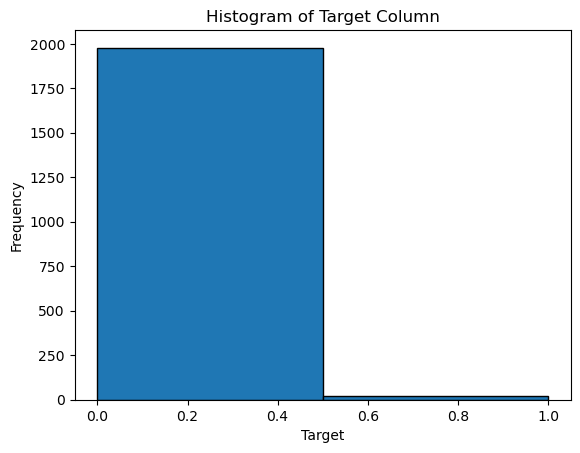

In [123]:
# Create histogram for the "target" column
plt.hist(df['target'], bins=2, edgecolor='black')
plt.title('Histogram of Target Column')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\2944265773.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x1", data=df, palette=colors, ax=axes[0])
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\2944265773.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x5", data=df, palette=colors, ax=axes[1])
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\2944265773.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x5", data=df, palette=colors, ax=axes[2])


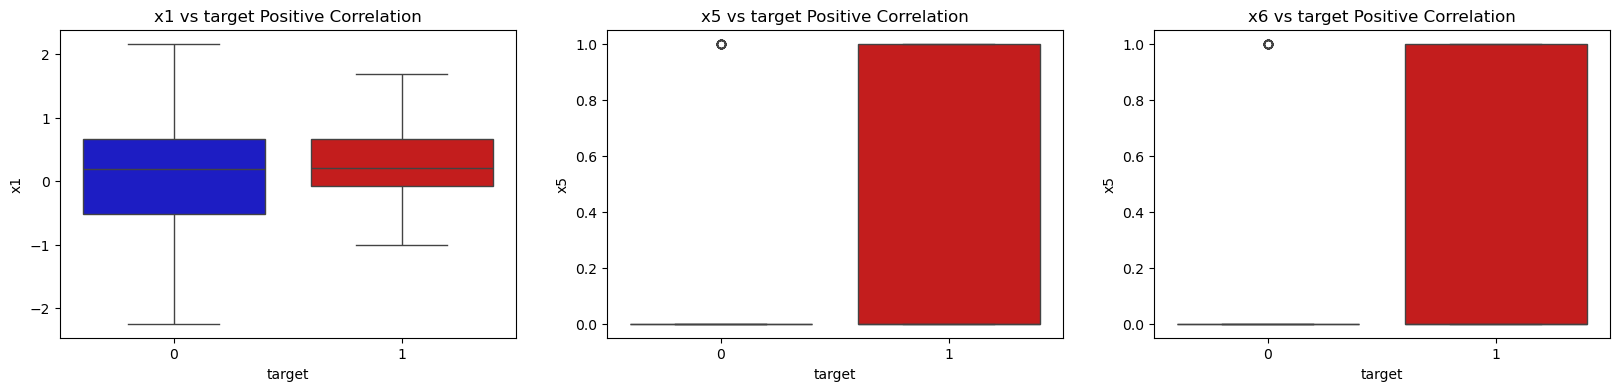

In [124]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="target", y="x1", data=df, palette=colors, ax=axes[0])
axes[0].set_title('x1 vs target Positive Correlation')

sns.boxplot(x="target", y="x5", data=df, palette=colors, ax=axes[1])
axes[1].set_title('x5 vs target Positive Correlation')


sns.boxplot(x="target", y="x5", data=df, palette=colors, ax=axes[2])
axes[2].set_title('x6 vs target Positive Correlation')


plt.show()

C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\3007467015.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\3007467015.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x3_fraud_dist,ax=ax2

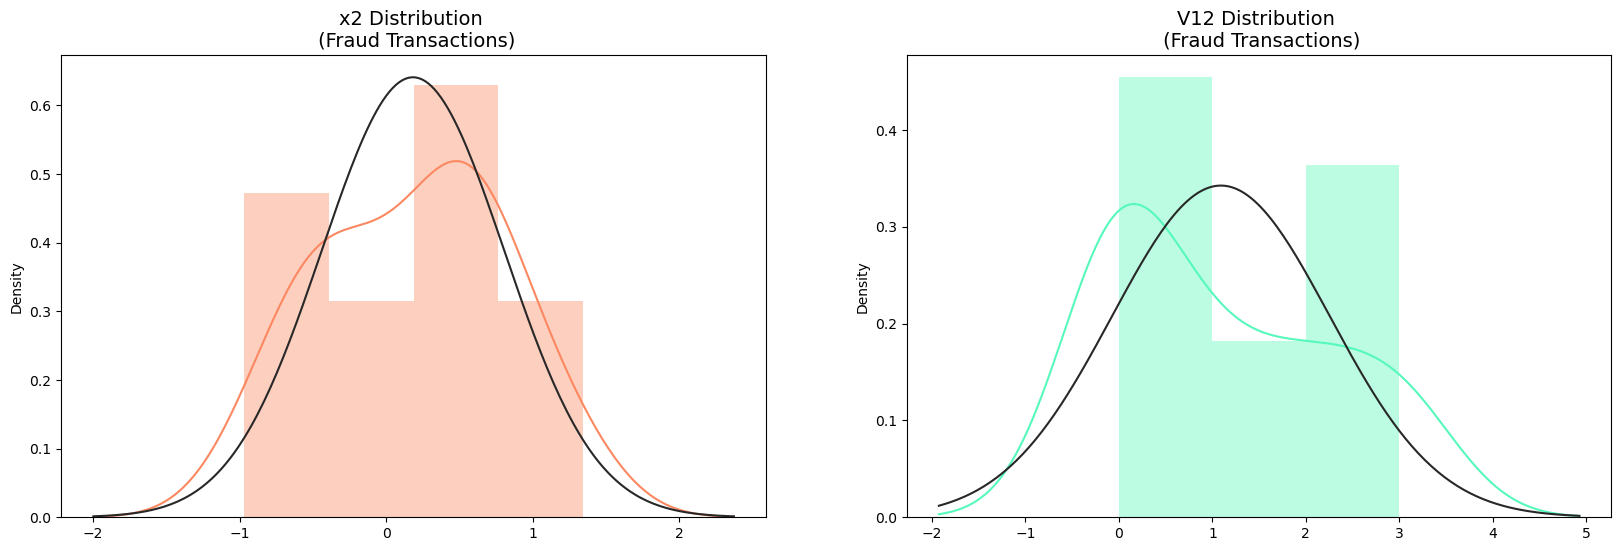

In [125]:
from scipy.stats import norm

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

x2_fraud_dist = df['x2'].loc[df['target'] == 1].values
sns.distplot(x2_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('x2 Distribution \n (Fraud Transactions)', fontsize=14)

x3_fraud_dist = df['x3'].loc[df['target'] == 1].values
sns.distplot(x3_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

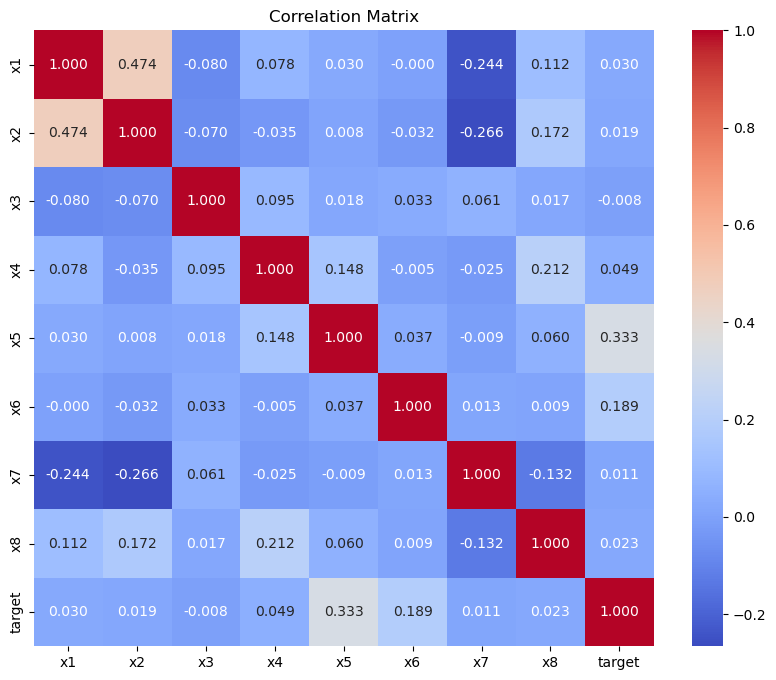

In [126]:
# Compute correlation matrix with 3 decimal precision and plot
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

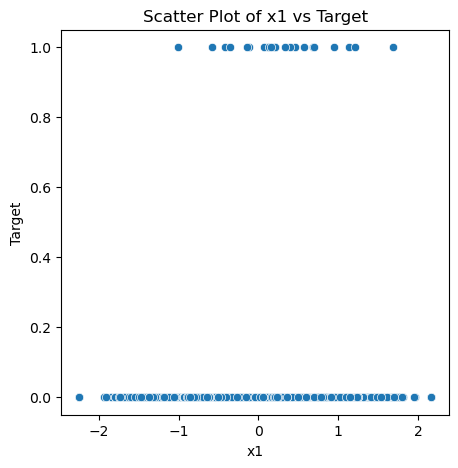

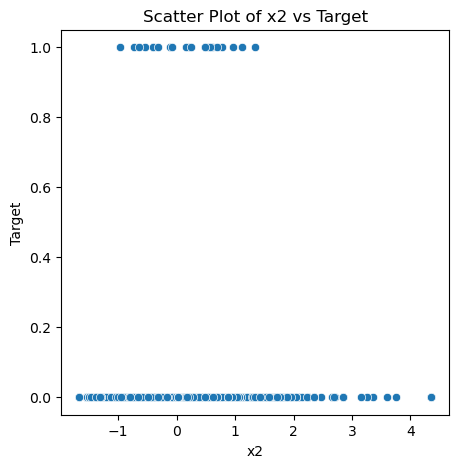

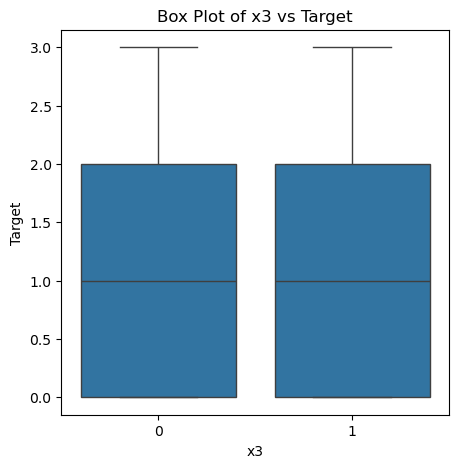

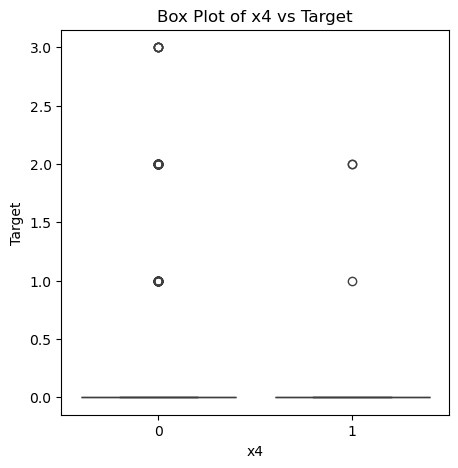

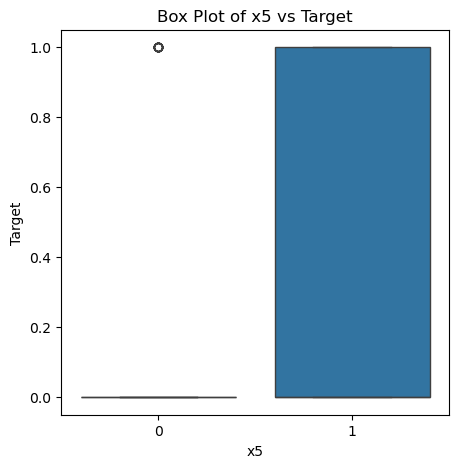

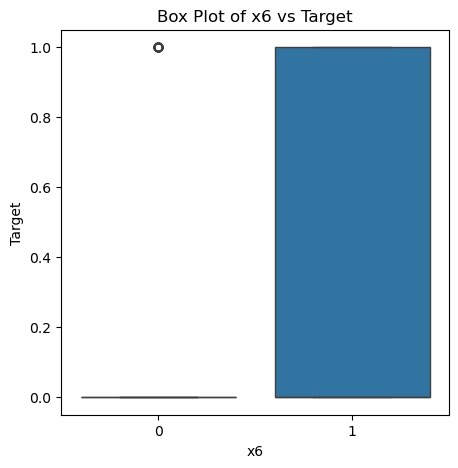

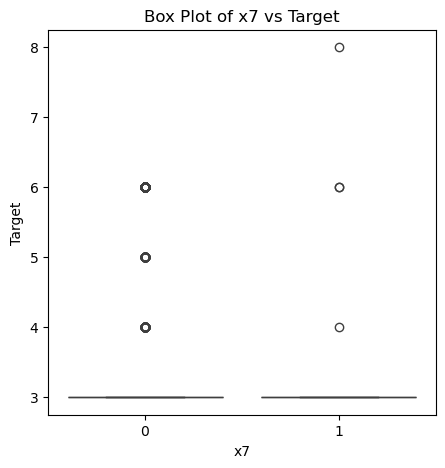

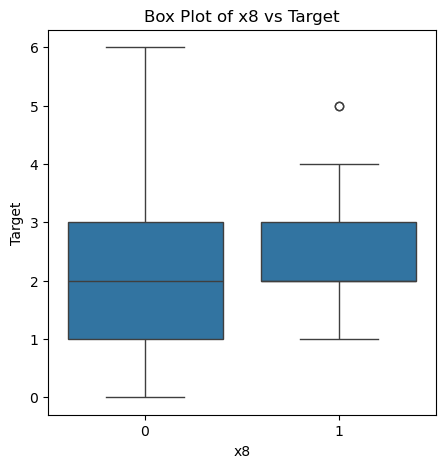

In [29]:
for column in df.columns:
    if column != 'target':
        plt.figure(figsize=(5,5))
        if df[column].dtype == 'float64':
            sns.scatterplot(x=df[column], y=df['target'])
            plt.title(f'Scatter Plot of {column} vs Target')
        else:
            sns.boxplot(x=df['target'], y=df[column])
            plt.title(f'Box Plot of {column} vs Target')
        plt.xlabel(column)
        plt.ylabel('Target')
        plt.show()

## Undersampling

In [75]:
X = df.drop('target', axis=1)
y = df['target']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.989375 0.010625]
[0.9875 0.0125]


In [76]:
# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 400 rows.
fraud_df = df.loc[df['target'] == 1]
non_fraud_df = df.loc[df['target'] == 0][:df['target'].value_counts()[1]*9]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,target
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,-0.089335,-0.094019,1.136364,0.063636,0.040909,0.050000,3.518182,2.136364,0.100000
std,1.026109,0.956133,1.142594,0.324840,0.198531,0.218442,1.048868,1.534845,0.300684
min,-2.247572,-1.670521,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,-0.539944,-0.715133,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
50%,0.139847,-0.035637,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000
75%,0.560261,0.530730,2.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000
max,2.164555,4.356356,3.000000,2.000000,1.000000,1.000000,8.000000,6.000000,1.000000


Distribution of the Classes in the subsample dataset
target
0    0.9
1    0.1
Name: count, dtype: float64


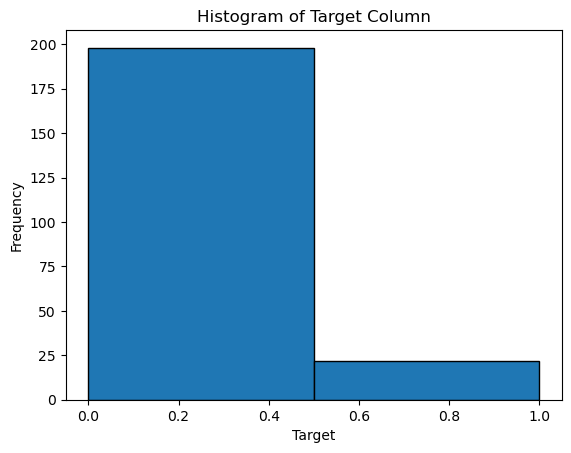

In [77]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['target'].value_counts()/len(new_df))

plt.hist(new_df['target'], bins=2, edgecolor='black')
plt.title('Histogram of Target Column')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

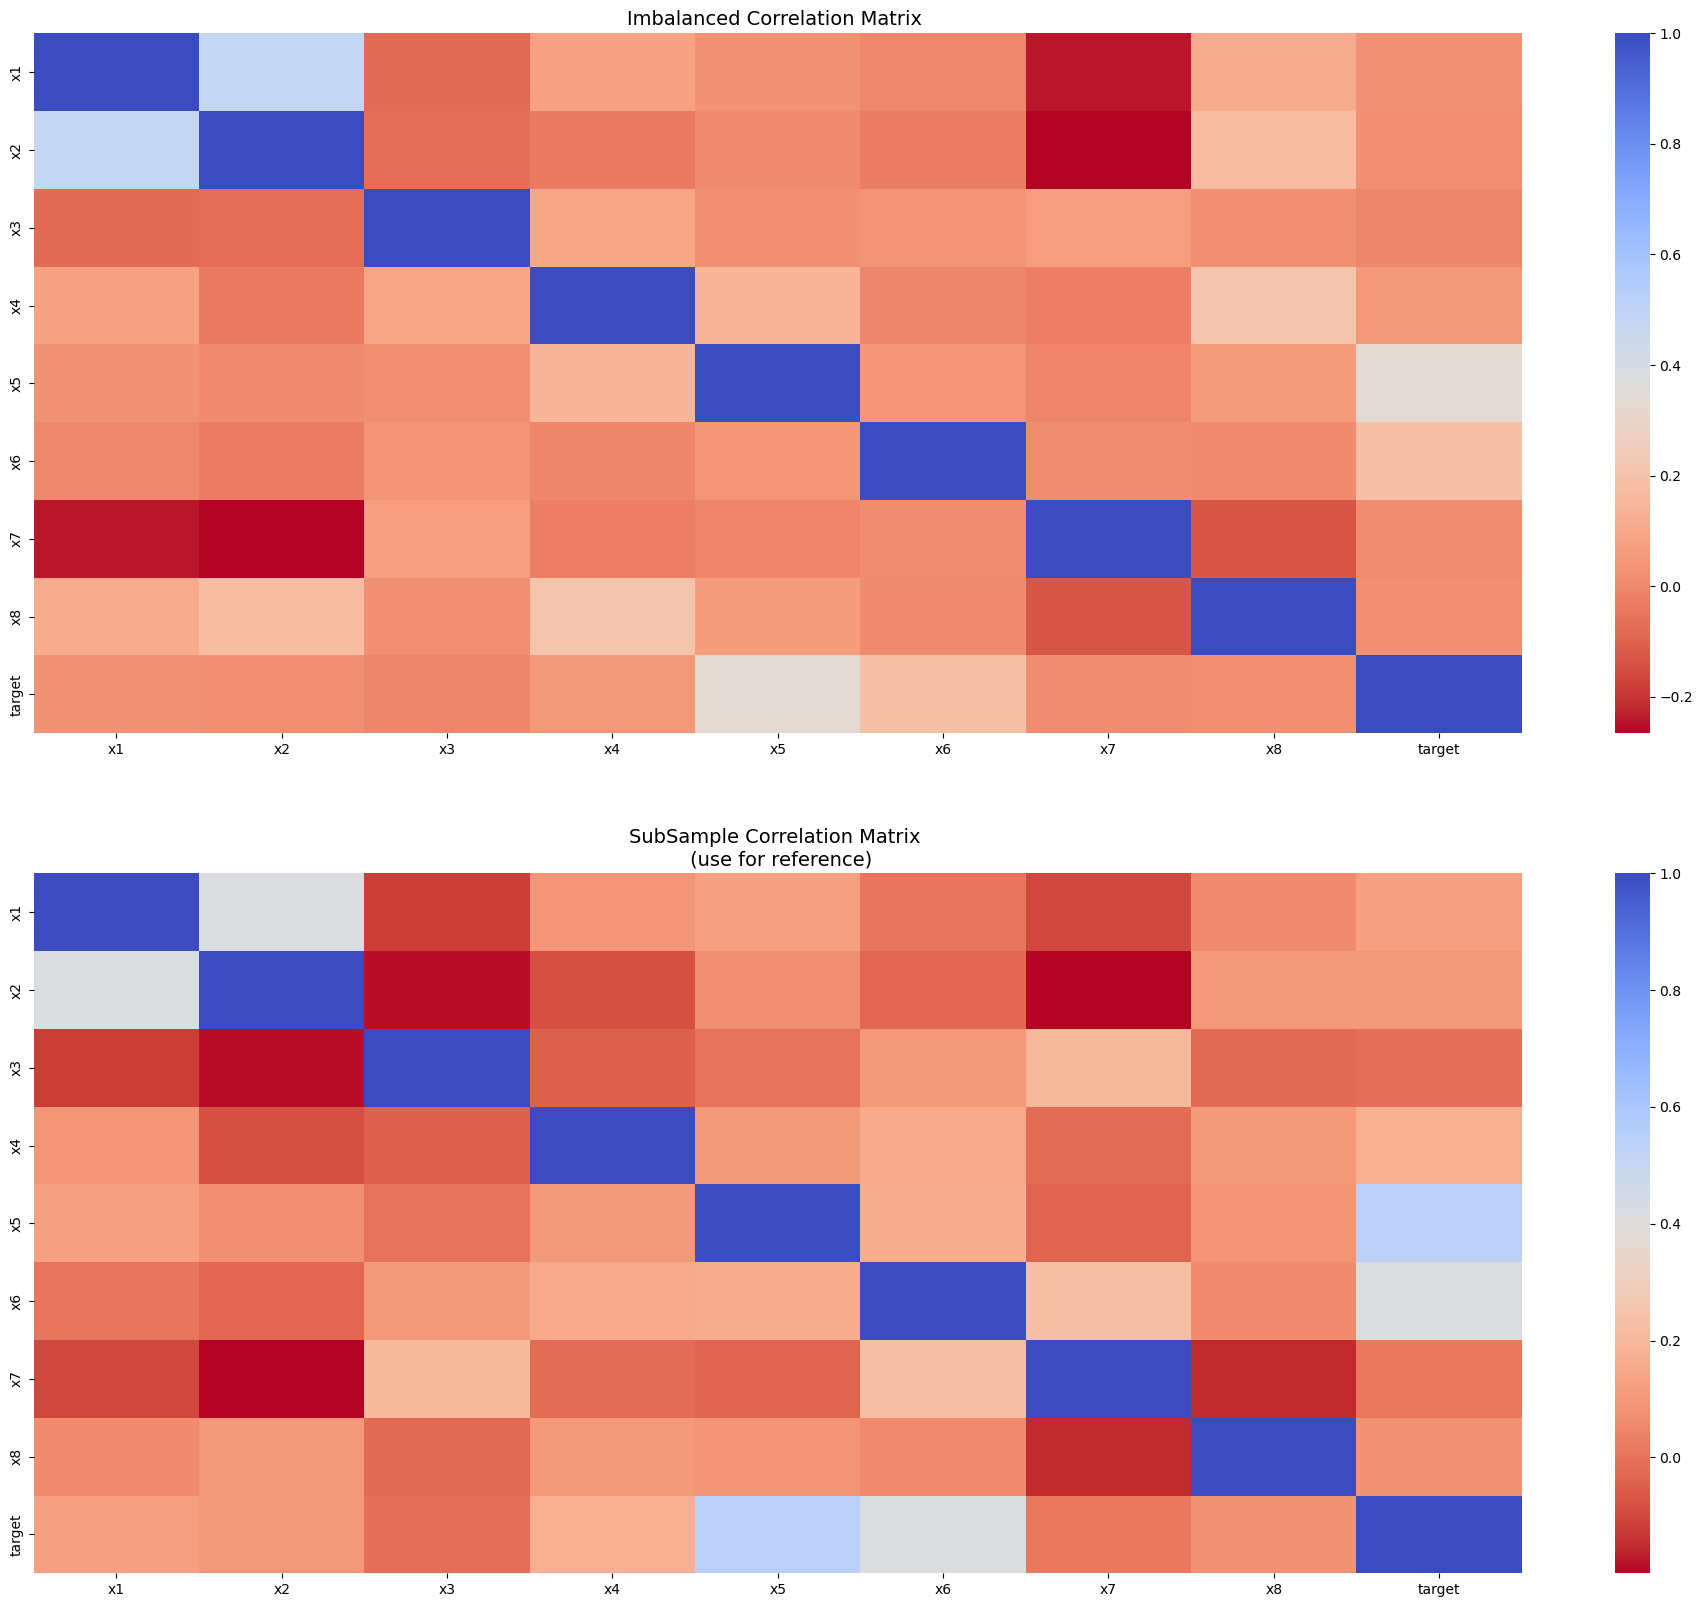

In [137]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix ", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\3817511520.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x2", data=new_df, palette=colors, ax=axes[0])
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\3817511520.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x3", data=new_df, palette=colors, ax=axes[1])


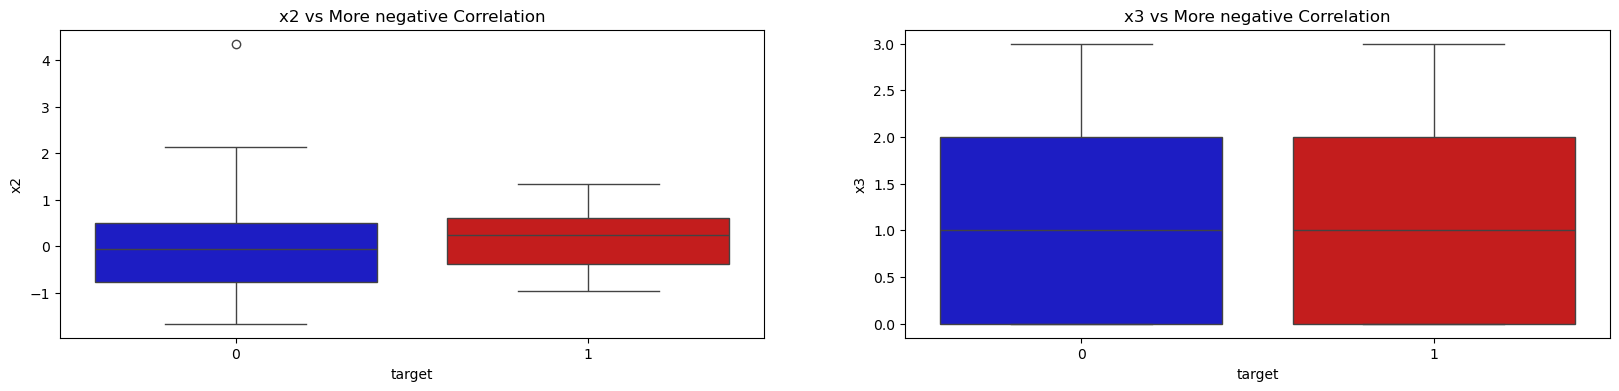

In [79]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Negative Correlations with our target(The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="target", y="x2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('x2 vs More negative Correlation')

sns.boxplot(x="target", y="x3", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('x3 vs More negative Correlation')

plt.show()

C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\4087077202.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x1", data=new_df, palette=colors, ax=axes[0])
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\4087077202.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x5", data=new_df, palette=colors, ax=axes[1])
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\4087077202.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="x5", data=new_df, palette=colors, ax=axes[2])


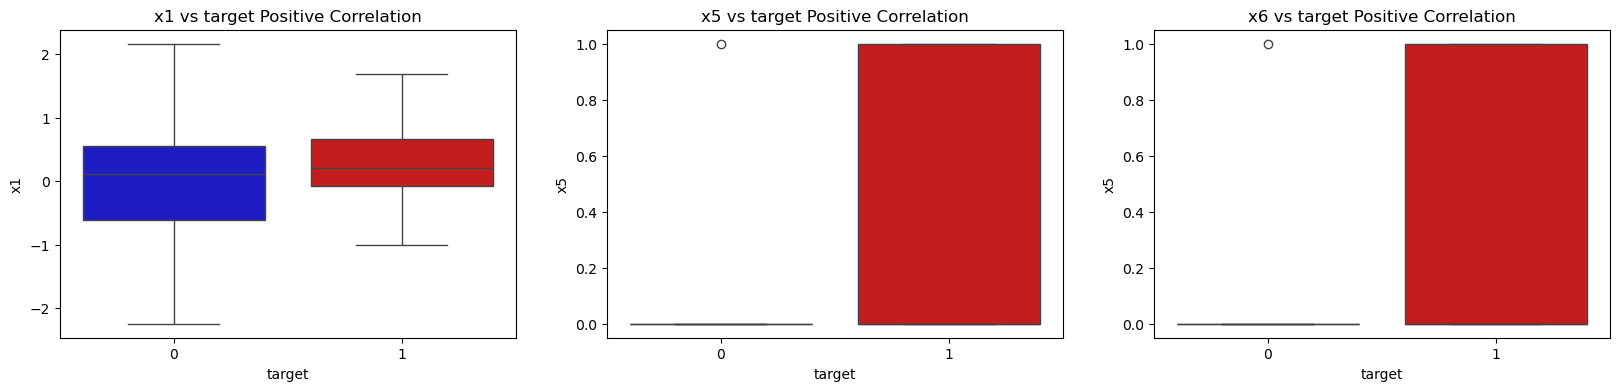

In [80]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="target", y="x1", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('x1 vs target Positive Correlation')

sns.boxplot(x="target", y="x5", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('x5 vs target Positive Correlation')


sns.boxplot(x="target", y="x5", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('x6 vs target Positive Correlation')


plt.show()

C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\2543607691.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\aaihs\AppData\Local\Temp\ipykernel_21180\2543607691.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x3_fraud_dist,ax=ax2

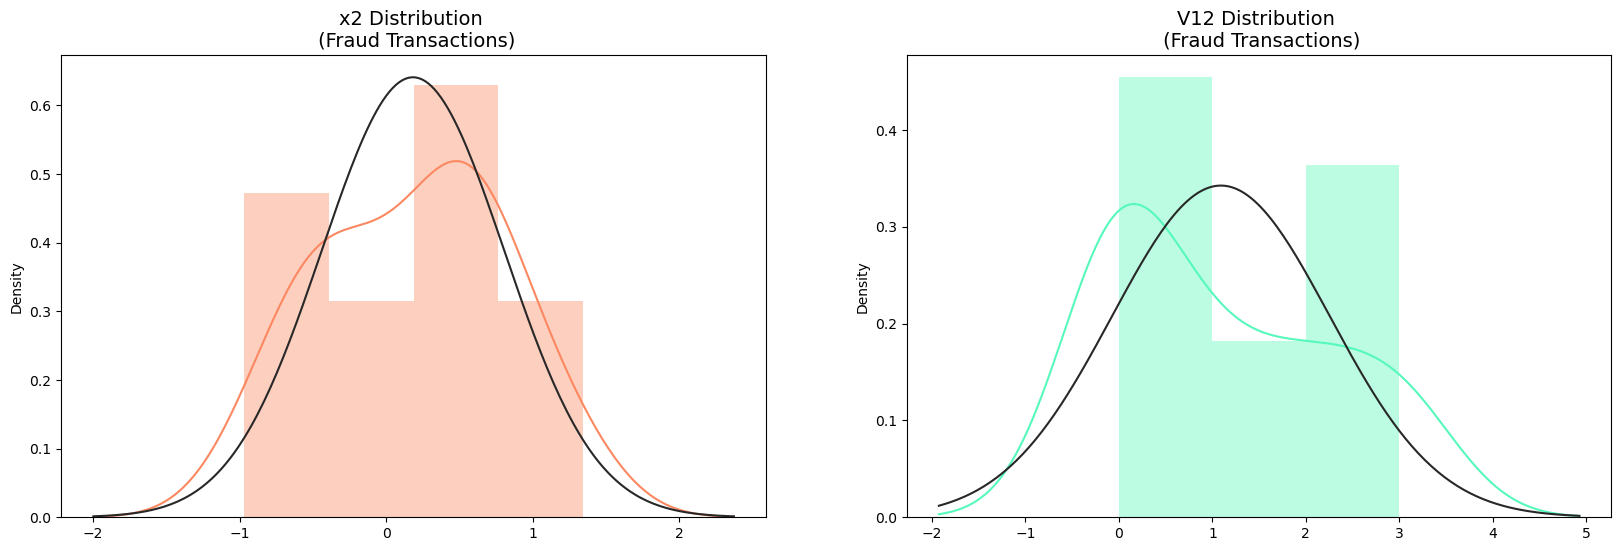

In [81]:
from scipy.stats import norm

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

x2_fraud_dist = new_df['x2'].loc[new_df['target'] == 1].values
sns.distplot(x2_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('x2 Distribution \n (Fraud Transactions)', fontsize=14)

x3_fraud_dist = new_df['x3'].loc[new_df['target'] == 1].values
sns.distplot(x3_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

## Dim reduction

In [82]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('target', axis=1)
y = new_df['target']

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)


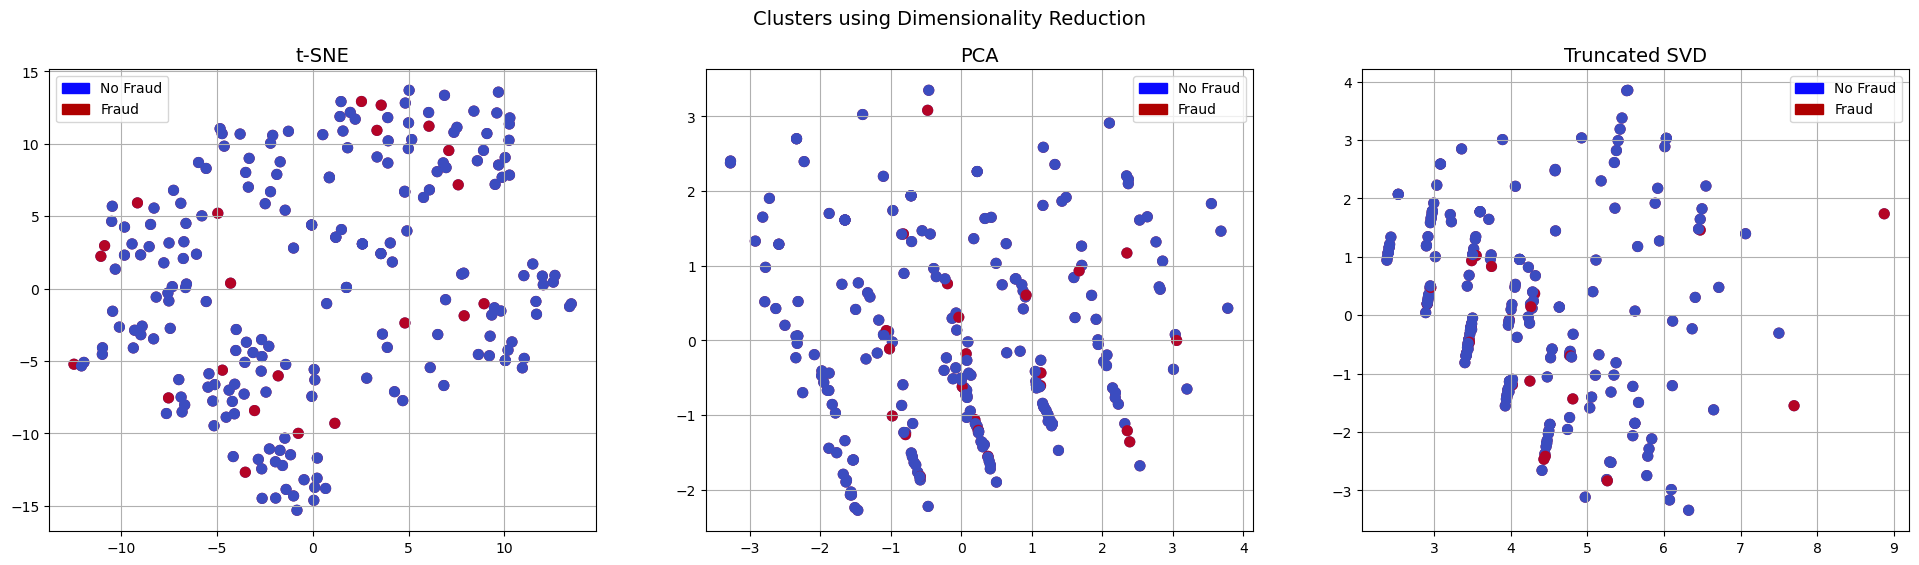

In [83]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

Not a good apporeach to solve the problem.

## Classifiar


In [97]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('target', axis=1)
y = new_df['target']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Let's implement simple classifiers

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier()
}

# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 90.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 84.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 90.0 % accuracy score
Classifiers:  GradientBoostingClassifier Has a training score of 91.0 % accuracy score
Classifiers:  SVC Has a training score of 90.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 90.0 % accuracy score
Classifiers:  GaussianNB Has a training score of 90.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 89.0 % accuracy score


22

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Logistic Regression 
log_reg_params = {
    "C": np.logspace(-3, 3, 7),
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"]  # Add solvers that support 'l1' penalty
}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_


c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn

In [92]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\aaihs\\anaconda3\\envs\\CLAC\\lib\\site-packages\\matplotlib\\pyplot.py'>

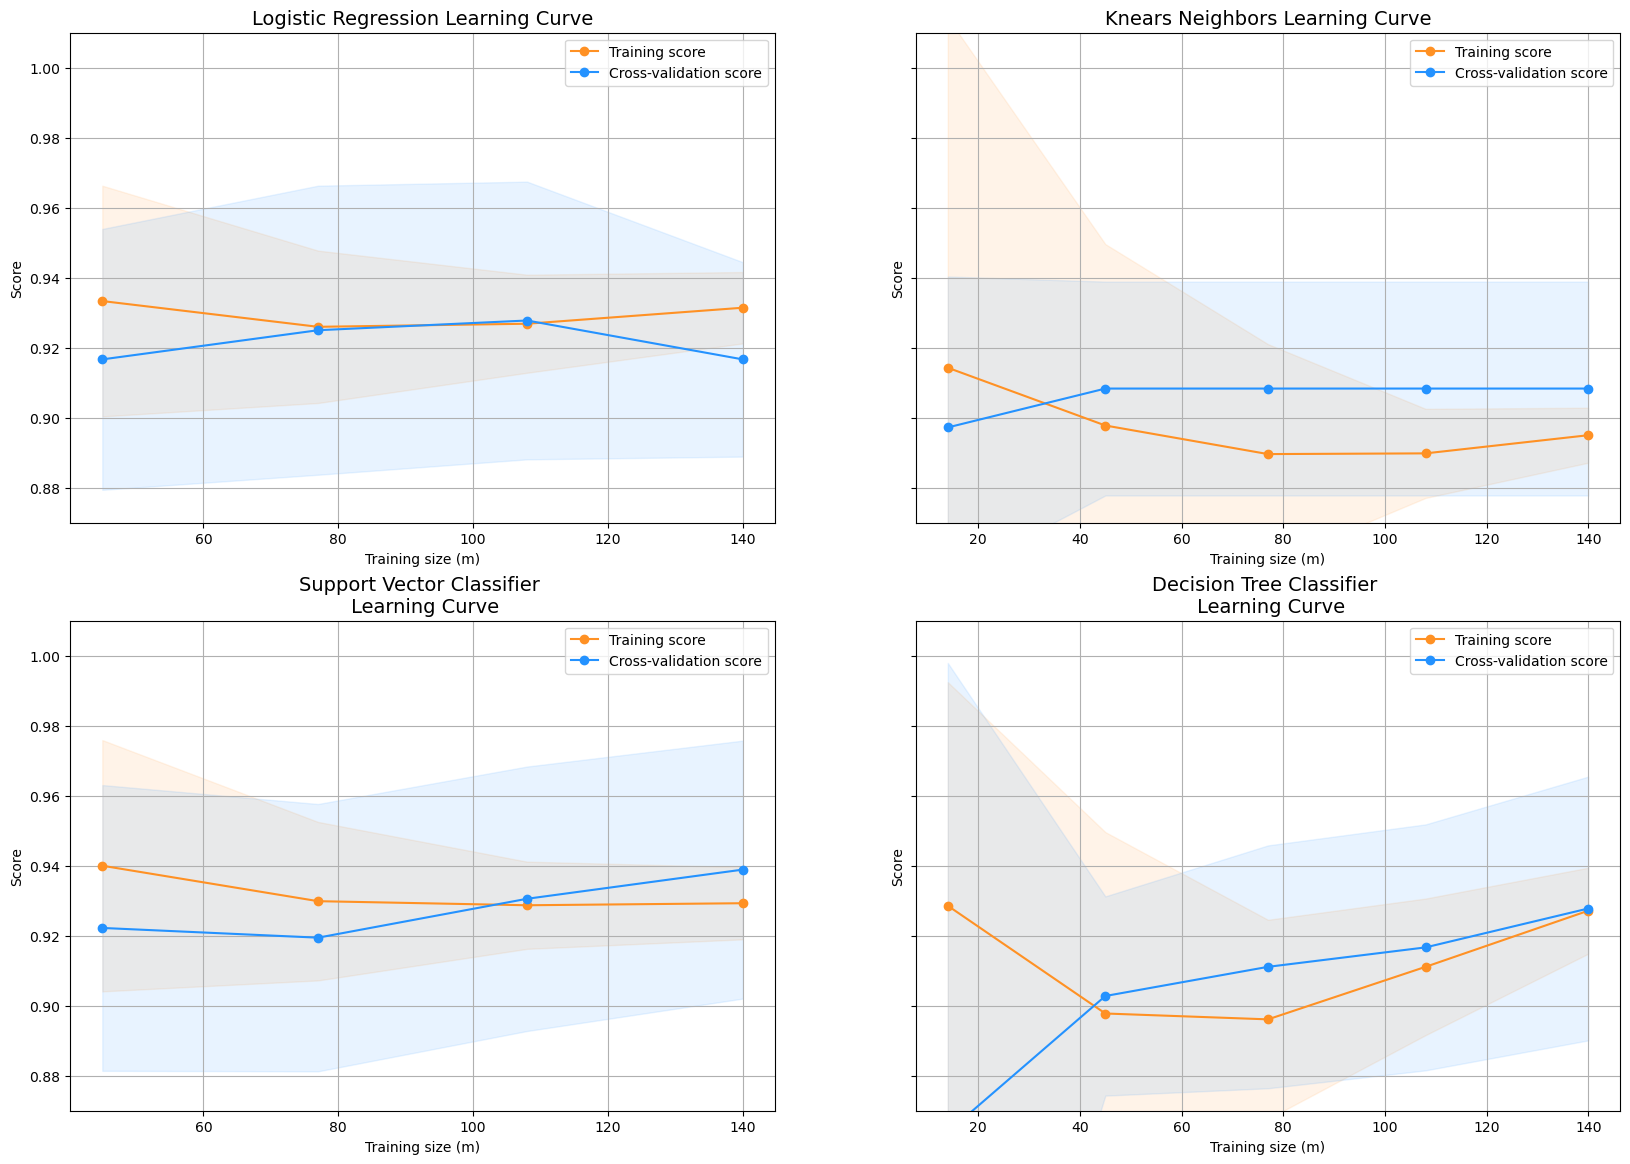

In [107]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [94]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [95]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.7123769338959212
KNears Neighbors:  0.5
Support Vector Classifier:  0.7021800281293953
Decision Tree Classifier:  0.6912798874824191


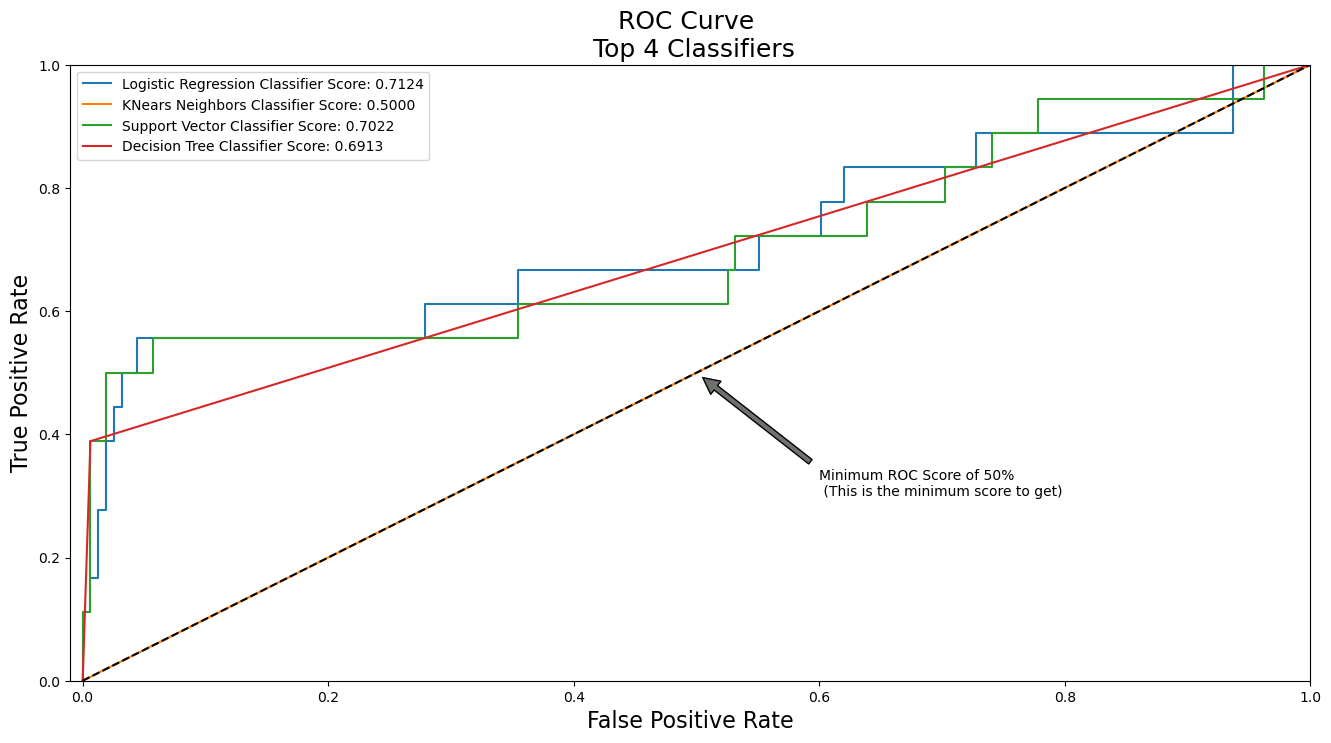

In [96]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## SMOTE method


In [155]:
# New_df is from the random undersample data (fewer instances)
X = df.drop('target', axis=1)
y = df['target']

oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

# Split the data into training and testing sets with relation 80/20, respectively
X_train, X_test, y_train, y_test = train_test_split(over_X, over_y, test_size=0.2, random_state=42)

# List of models to try
model = RandomForestClassifier(n_estimators=150, random_state=0)

# Train and evaluate each model
model.fit(X_train, y_train)
name = "RF"      

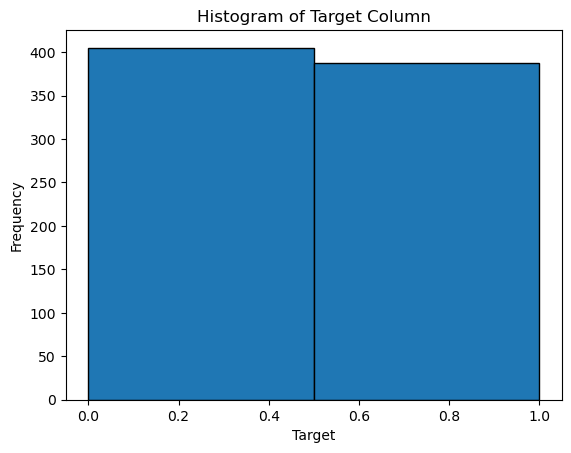

In [134]:
# Create histogram for the "target" column
plt.hist(y_test, bins=2, edgecolor='black')
plt.title('Histogram of Target Column')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

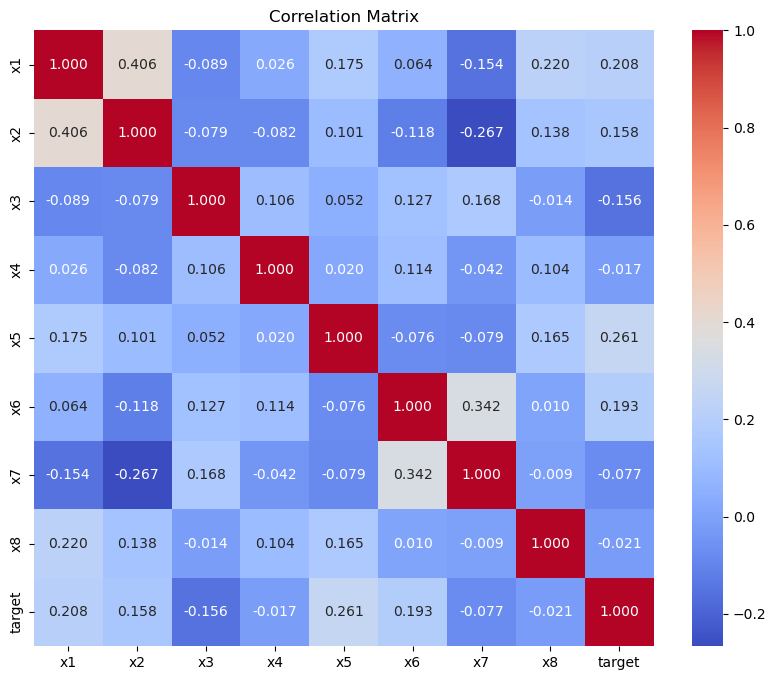

In [135]:
oversampled_df = pd.DataFrame(over_X, columns=X.columns)
oversampled_df['target'] = over_y
# Compute correlation matrix with 3 decimal precision and plot
corr_matrix = oversampled_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

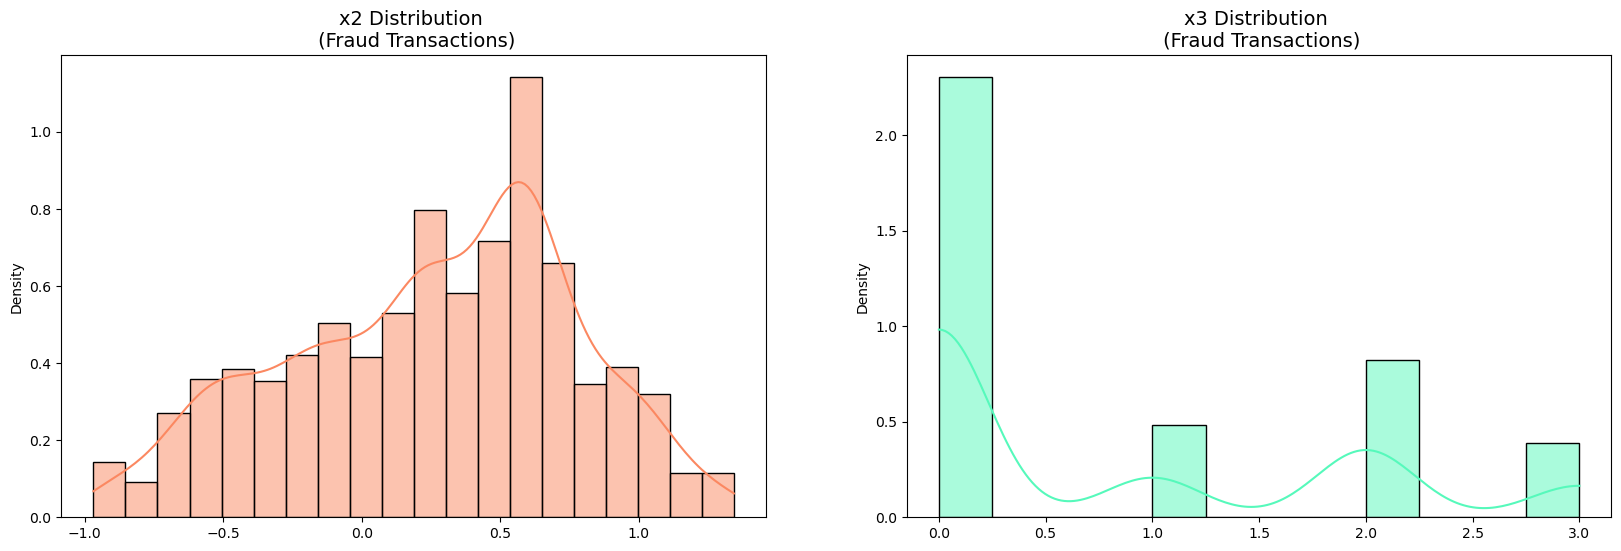

In [166]:
from scipy.stats import norm

# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# x2 Distribution for Fraud Transactions
x2_fraud_dist = oversampled_df['x2'].loc[oversampled_df['target'] == 1].values
sns.histplot(x2_fraud_dist, ax=ax1, kde=True, stat="density", color='#FB8861')
ax1.set_title('x2 Distribution \n (Fraud Transactions)', fontsize=14)

# x3 Distribution for Fraud Transactions
x3_fraud_dist = oversampled_df['x3'].loc[oversampled_df['target'] == 1].values
sns.histplot(x3_fraud_dist, ax=ax2, kde=True, stat="density", color='#56F9BB')
ax2.set_title('x3 Distribution \n (Fraud Transactions)', fontsize=14)

# Show the plot
plt.show()

In [141]:
oversampled_df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,target
count,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000,3956.000000
mean,0.166304,0.125734,0.999494,0.059656,0.079120,0.074317,3.367543,2.124368,0.500000
std,0.813785,0.807640,1.129089,0.290569,0.269961,0.262320,0.933380,1.334063,0.500063
min,-2.247572,-1.670521,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,-0.133350,-0.365129,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
50%,0.244243,0.215516,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.500000
75%,0.627447,0.615534,2.000000,0.000000,0.000000,0.000000,3.000000,3.000000,1.000000
max,2.164555,4.356356,3.000000,3.000000,1.000000,1.000000,8.000000,6.000000,1.000000


## Model

In [157]:
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets with relation 80/20, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use SMOTe to oversample the data
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_train, y_train)


In [167]:
## Random Forest

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],  # Removed 'auto'
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=1, class_weight='balanced')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           n_jobs=-1, 
                           verbose=2)

# Fit the model
grid_search.fit(over_X, over_y)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Train and evaluate the best model
best_rf.fit(over_X, over_y)
name = "RF" 

# Predictions and probabilities for test set
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

# Predictions and probabilities for train set
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train)

# Calculate accuracy, AUC, F1 score, precision, and recall for test set
auc_test = roc_auc_score(y_test, y_pred_proba_test)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test,  y_pred_test)

# Calculate AUC score for train set
auc_train = roc_auc_score(y_train, y_pred_proba_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [163]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(model, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))


Mean f1: 0.935
Mean recall: 0.963
Mean precision: 0.909


In [145]:

print(f"{name} - Test AUC: {auc_test:.4f}, Test F1: {f1_test:.4f}, Test Precision: {precision_test:.4f}, Test Recall: {recall_test:.4f}")
print(f"{name} - Train AUC: {auc_train:.4f}")

RF - Test AUC: 0.9837, Test F1: 0.0000, Test Precision: 0.0000, Test Recall: 0.0000
RF - Train AUC: 1.0000


    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(C = 10,kernel ='poly', degree = 3),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier()

## otros calculos

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets with relation 80/20, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to try
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(C=10, kernel='poly', degree=3, probability=True),  # Enable probability estimates
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions and probabilities for test set
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # Predictions and probabilities for train set
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train)
    
    # Calculate accuracy, AUC, and F1 score for test set
    auc_test = roc_auc_score(y_test, y_pred_proba_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    # Calculate accuracy, AUC, and F1 score for train set
    auc_train = roc_auc_score(y_train, y_pred_proba_train)
    f1_train = f1_score(y_train, y_pred_train)
    
    # Print AUC and F1 scores
    print(f"{name} - Test AUC: {auc_test:.4f}, Test F1: {f1_test:.4f}")
    print(f"{name} - Train AUC: {auc_train:.4f}")
    
    # Print classification report for test set
    print(f"Classification Report for {name} (Test Set):")
    print(classification_report(y_test, y_pred_test))
    
    # Print classification report for train set
    print(f"Classification Report for {name} (Train Set):")
    print(classification_report(y_train, y_pred_train))

Logistic Regression - Test AUC: 0.9825, Test F1: 0.0000
Logistic Regression - Train AUC: 0.8045
Classification Report for Logistic Regression (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       399
           1       0.00      0.00      0.00         1

    accuracy                           1.00       400
   macro avg       0.50      0.50      0.50       400
weighted avg       1.00      1.00      1.00       400

Classification Report for Logistic Regression (Train Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1579
           1       1.00      0.10      0.17        21

    accuracy                           0.99      1600
   macro avg       0.99      0.55      0.58      1600
weighted avg       0.99      0.99      0.98      1600

Decision Tree - Test AUC: 0.4937, Test F1: 0.0000
Decision Tree - Train AUC: 1.0000
Classification Report for Decision Tree (Test Set

c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest - Test AUC: 0.9850, Test F1: 0.0000
Random Forest - Train AUC: 1.0000
Classification Report for Random Forest (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       399
           1       0.00      0.00      0.00         1

    accuracy                           0.99       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.99      0.99      0.99       400

Classification Report for Random Forest (Train Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1579
           1       1.00      1.00      1.00        21

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Gradient Boosting - Test AUC: 0.7193, Test F1: 0.0000
Gradient Boosting - Train AUC: 1.0000
Classification Report for Gradient Boosting (Test Set):
         

c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       399
           1       0.00      0.00      0.00         1

    accuracy                           0.99       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.99      0.99      0.99       400

Classification Report for XGBoost (Train Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1579
           1       1.00      1.00      1.00        21

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [99]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
import pandas as pd

X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets with relation 80/20, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4],  # Only relevant for 'poly' kernel
    'gamma': ['scale', 'auto']
}

# Initialize the SVC model
svc = SVC(probability=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_svc = grid_search.best_estimator_

# Predictions and probabilities for test set
y_pred_test = best_svc.predict(X_test)
y_pred_proba_test = best_svc.predict_proba(X_test)[:, 1]

# Predictions and probabilities for train set
y_pred_train = best_svc.predict(X_train)
y_pred_proba_train = best_svc.predict_proba(X_train)[:, 1]

# Calculate AUC for test set
auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculate AUC for train set
auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Print AUC scores
print(f"SVC - Test AUC: {auc_test:.4f}")
print(f"SVC - Train AUC: {auc_train:.4f}")

# Print classification report for test set
print(f"Classification Report for SVC (Test Set):")
report_test = classification_report(y_test, y_pred_test, output_dict=True)
report_test['AUC'] = auc_test
print(pd.DataFrame(report_test).transpose())

# Print classification report for train set
print(f"Classification Report for SVC (Train Set):")
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_train['AUC'] = auc_train
print(pd.DataFrame(report_train).transpose())

# Print the best parameters found by GridSearchCV
print(f"Best parameters found by GridSearchCV: {grid_search.best_params_}")

c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "

SVC - Test AUC: 0.8571
SVC - Train AUC: 0.8627
Classification Report for SVC (Test Set):
              precision    recall  f1-score     support
0              0.997500  1.000000  0.998748  399.000000
1              0.000000  0.000000  0.000000    1.000000
accuracy       0.997500  0.997500  0.997500    0.997500
macro avg      0.498750  0.500000  0.499374  400.000000
weighted avg   0.995006  0.997500  0.996252  400.000000
AUC            0.857143  0.857143  0.857143    0.857143
Classification Report for SVC (Train Set):
              precision    recall  f1-score      support
0              0.986875  1.000000  0.993394  1579.000000
1              0.000000  0.000000  0.000000    21.000000
accuracy       0.986875  0.986875  0.986875     0.986875
macro avg      0.493437  0.500000  0.496697  1600.000000
weighted avg   0.973922  0.986875  0.980356  1600.000000
AUC            0.862662  0.862662  0.862662     0.862662
Best parameters found by GridSearchCV: {'C': 0.1, 'degree': 2, 'gamma': 'scal

c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\envs\CLAC\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aaihs\anaconda3\

## Model


## REFERENCES

https://medium.com/game-of-bits/how-to-deal-with-imbalanced-data-in-classification-bd03cfc66066
https://www.statology.org/auc-in-python/